# Main imports and code

In [1]:
# check which gpu we're using
!nvidia-smi

Fri Feb 13 13:28:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import numpy as np
from urllib import request
import pandas as pd
import logging
import torch
import csv
import re
import ast
import html
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [3]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [4]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Dev, train and test datasets preparation

In [5]:
#  Load main dataset ---
DATA_URL = "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"

columns = ["par_id", "art_id", "keyword", "country_code", "text", "label"]

df = pd.read_csv(
    DATA_URL,
    sep="\t",
    header=None,
    names=columns,
    engine="python",
    quoting=csv.QUOTE_NONE
)

# --- Add binary labels ---
df["binary_label"] = df["label"].apply(lambda x: 0 if x in [0, 1] else 1)
df["par_id"] = df["par_id"].astype(str)

# --- Load train/dev split CSVs (contains PCL type vectors) ---
train_split_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
dev_split_url   = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"

train_split = pd.read_csv(train_split_url)
dev_split   = pd.read_csv(dev_split_url)

# -- Add the cathegory vector --
train_split["type_vector"] = train_split["label"].apply(ast.literal_eval)
dev_split["type_vector"]   = dev_split["label"].apply(ast.literal_eval)

train_split["par_id"] = train_split["par_id"].astype(str)
dev_split["par_id"]   = dev_split["par_id"].astype(str)

train_ids = train_split["par_id"]
dev_ids   = dev_split["par_id"]

# --- Create final train/dev dataframes ---
train_df = df[df["par_id"].isin(train_ids)].reset_index(drop=True)
dev_df   = df[df["par_id"].isin(dev_ids)].reset_index(drop=True)

# attach type_vector to train/dev
train_df = train_df.merge(train_split[["par_id", "type_vector"]], on="par_id", how="left")
dev_df   = dev_df.merge(dev_split[["par_id", "type_vector"]], on="par_id", how="left")

# --- Load TEST set (no labels) ---
TEST_URL = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv"

test_columns = ["par_id", "art_id", "keyword", "country_code", "text"]
test_df = pd.read_csv(
    TEST_URL,
    sep="\t",
    header=None,
    names=test_columns,
    engine="python",
    quoting=csv.QUOTE_NONE
)
test_df["par_id"] = test_df["par_id"].astype(str)

# --- 5) Sanity checks ---
print("Train size:", len(train_df))
print("Dev size:", len(dev_df))
print("Test size:", len(test_df))

print("\nTrain label distribution:")
print(train_df["binary_label"].value_counts())

print("\nDev label distribution:")
print(dev_df["binary_label"].value_counts())

print("\nType vector present (dev):", dev_df["type_vector"].notna().mean())

train_df.head()


Train size: 8375
Dev size: 2094
Test size: 3832

Train label distribution:
binary_label
0    7581
1     794
Name: count, dtype: int64

Dev label distribution:
binary_label
0    1895
1     199
Name: count, dtype: int64

Type vector present (dev): 1.0


,par_id,art_id,keyword,country_code,text,label,binary_label,type_vector
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0.0,0,"[0, 0, 0, 0, 0, 0, 0]"
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0.0,0,"[0, 0, 0, 0, 0, 0, 0]"
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0.0,0,"[0, 0, 0, 0, 0, 0, 0]"
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0.0,0,"[0, 0, 0, 0, 0, 0, 0]"
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0.0,0,"[0, 0, 0, 0, 0, 0, 0]"


# Pre-processing

## Lib

In [6]:
URL_REGEX = r"(https?://\S+|www\.\S+)"
EMAIL_REGEX = r"\b[\w\.-]+@[\w\.-]+\.\w+\b"
SPACE_BEFORE_PUNCT_REGEX = r"\s+([.,!?;:%])"

def clean_raw_text(text):
    if text is None:
        return ""
    text = str(text)
    text = re.sub(r"<.*?>", " ", text)          # HTML tags
    text = html.unescape(text)                  # HTML entities
    text = re.sub(r"[\n\r\t]", " ", text)       # newlines/tabs
    text = "".join(ch if ch.isprintable() else " " for ch in text)  # control chars
    text = re.sub(r"\s+", " ", text).strip()    # whitespace
    return text

def normalize_quotes(text):
    if text is None:
        return ""
    text = str(text)
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("‘", "'").replace("’", "'")
    text = text.replace("´", "'").replace("`", "'")
    text = text.replace("``", '"').replace("''", '"')
    text = re.sub(r"\"{2,}", '"', text)         # """ -> "
    text = re.sub(r"'{2,}", "'", text)          # ''' -> '
    return text

def remove_space_before_punct(text):
    if text is None:
        return ""
    return re.sub(SPACE_BEFORE_PUNCT_REGEX, r"\1", str(text))

def replace_urls_emails(text):
    if text is None:
        return ""
    text = str(text)
    text = re.sub(URL_REGEX, " <URL> ", text)
    text = re.sub(EMAIL_REGEX, " <EMAIL> ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [7]:
def preprocess_text_with_report(series, prefix=""):
    series = series.fillna("").astype(str)

    def step(old, fn):
        new = old.apply(fn)
        changed = (old != new).sum()
        total = len(old)
        print(f"{prefix}{fn.__name__}: {changed}/{total} rows affected ({changed/total:.1%})")
        return new

    s = series
    s = step(s, clean_raw_text)
    s = step(s, normalize_quotes)
    s = step(s, remove_space_before_punct)
    s = step(s, replace_urls_emails)
    return s

## Application on dev and train sets

In [8]:
train_df["text"] = preprocess_text_with_report(train_df["text"], prefix="Train | ")
dev_df["text"] = preprocess_text_with_report(dev_df["text"],   prefix="Dev   | ")
test_df["text"] = preprocess_text_with_report(test_df["text"],   prefix="Test   | ")

Train | clean_raw_text: 374/8375 rows affected (4.5%)
Train | normalize_quotes: 2095/8375 rows affected (25.0%)
Train | remove_space_before_punct: 8145/8375 rows affected (97.3%)
Train | replace_urls_emails: 8/8375 rows affected (0.1%)
Dev   | clean_raw_text: 95/2094 rows affected (4.5%)
Dev   | normalize_quotes: 504/2094 rows affected (24.1%)
Dev   | remove_space_before_punct: 2038/2094 rows affected (97.3%)
Dev   | replace_urls_emails: 2/2094 rows affected (0.1%)
Test   | clean_raw_text: 148/3832 rows affected (3.9%)
Test   | normalize_quotes: 989/3832 rows affected (25.8%)
Test   | remove_space_before_punct: 3730/3832 rows affected (97.3%)
Test   | replace_urls_emails: 4/3832 rows affected (0.1%)


# Best Model - RoBerta base with upsampling & 2 training epochs


In [9]:
# --- Upsampling
pos_df = train_df[train_df["binary_label"] == 1]
neg_df = train_df[train_df["binary_label"] == 0]

n_pos, n_neg = len(pos_df), len(neg_df)

# make negatives == 2 * positives (1:2), i.e. positives == n_neg//2
pos_upsampled = pos_df.sample(n=(n_neg // 2), replace=True, random_state=42)

train_df_balanced = (
    pd.concat([neg_df, pos_upsampled])
      .sample(frac=1, random_state=42)
      .reset_index(drop=True)
)

print("Before balancing:\n", train_df["binary_label"].value_counts())
print("After balancing:\n", train_df_balanced["binary_label"].value_counts())


Before balancing:
 binary_label
0    7581
1     794
Name: count, dtype: int64
After balancing:
 binary_label
0    7581
1    3790
Name: count, dtype: int64


In [10]:
MODEL_NAME = "roberta-base"  # also tried "roberta-large" & "microsoft/deberta-v3-base"
EPOCHS = 2

# --- model/tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.float()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=256,
        padding=False,
    )

# --- Build HF datasets ---
train_df_balanced["binary_label"] = train_df_balanced["binary_label"].astype("int64")
dev_df["binary_label"] = dev_df["binary_label"].astype("int64")

train_hf = Dataset.from_pandas(
    train_df_balanced[["text", "binary_label"]].rename(columns={"binary_label": "labels"}),
    preserve_index=False,
)
dev_hf = Dataset.from_pandas(
    dev_df[["text", "binary_label"]].rename(columns={"binary_label": "labels"}),
    preserve_index=False,
)

# Tokenize
train_hf = train_hf.map(tokenize_batch, batched=True, remove_columns=["text"])
dev_hf   = dev_hf.map(tokenize_batch, batched=True, remove_columns=["text"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# warmup_steps instead of deprecated warmup_ratio
train_bs = 16
steps_per_epoch = (len(train_hf) + train_bs - 1) // train_bs
warmup_steps = int(0.06 * steps_per_epoch * EPOCHS)

training_args = TrainingArguments(
    output_dir="./roberta_task1",
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=warmup_steps,
    fp16=False,
    bf16=False,
    fp16_full_eval=False,
    report_to="none",
    max_grad_norm=1.0,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf,
    eval_dataset=dev_hf,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()
metrics


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/11371 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.225204,0.278471,0.905444,0.502008,0.628141,0.558036
2,0.062215,0.377968,0.923591,0.601036,0.582915,0.591837


{'eval_loss': 0.3779681622982025,
 'eval_accuracy': 0.9235912129894938,
 'eval_precision': 0.6010362694300518,
 'eval_recall': 0.5829145728643216,
 'eval_f1': 0.5918367346938775,
 'eval_runtime': 16.5488,
 'eval_samples_per_second': 126.535,
 'eval_steps_per_second': 3.988,
 'epoch': 2.0}

# Inference

In [11]:
# Predict on OFFICIAL dev + test and write dev.txt / test.txt (one 0/1 per line)

import numpy as np
from datasets import Dataset
from scipy.special import softmax

# ---- helper: build HF dataset + tokenize (expects you already defined tokenize_batch + have `trainer`) ----
def make_tok_ds(df, has_labels: bool):
    if has_labels:
        ds = Dataset.from_pandas(
            df[["text", "binary_label"]].rename(columns={"binary_label": "labels"}),
            preserve_index=False,
        )
    else:
        ds = Dataset.from_pandas(df[["text"]], preserve_index=False)

    ds = ds.map(tokenize_batch, batched=True, remove_columns=["text"])
    return ds

# ---- decision rule ----
THRESHOLD = 0.5

def predict_01(trainer, tok_ds, threshold=0.5):
    pred_out = trainer.predict(tok_ds)
    logits = pred_out.predictions
    probs_pos = softmax(logits, axis=-1)[:, 1]
    preds = (probs_pos >= threshold).astype(int)
    return preds

# ---- DEV predictions ----
dev_tok = make_tok_ds(dev_df, has_labels=True)
dev_preds = predict_01(trainer, dev_tok, threshold=THRESHOLD)

with open("dev.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(map(str, dev_preds.tolist())) + "\n")

print("Wrote dev.txt with", len(dev_preds), "predictions")

# ---- TEST predictions (no labels) ----
test_tok = make_tok_ds(test_df, has_labels=False)
test_preds = predict_01(trainer, test_tok, threshold=THRESHOLD)

with open("test.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(map(str, test_preds.tolist())) + "\n")

print("Wrote test.txt with", len(test_preds), "predictions")

# quick peek
print("dev.txt first 10:", dev_preds[:10].tolist())
print("test.txt first 10:", test_preds[:10].tolist())


Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

Wrote dev.txt with 2094 predictions


Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

Wrote test.txt with 3832 predictions
dev.txt first 10: [0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
test.txt first 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Error Analysis

In [12]:
# Sanity check - recompute f1 from dev.txt

# --- read predictions ---
with open("dev.txt", "r", encoding="utf-8") as f:
    preds = [int(line.strip()) for line in f if line.strip() != ""]

# --- ground truth from dev_df ---
y_true = dev_df["binary_label"].astype(int).tolist()

# sanity check
assert len(preds) == len(y_true), f"Length mismatch: preds={len(preds)} vs labels={len(y_true)}"

# --- metrics ---
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, preds, average="binary", zero_division=0
)
accuracy = accuracy_score(y_true, preds)

print(f"Accuracy : {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall   : {recall:.6f}")
print(f"F1 score : {f1:.6f}")

Accuracy : 0.923591
Precision: 0.601036
Recall   : 0.582915
F1 score : 0.591837


Dev size: 2094
Mispredictions: 160
Saved: dev_mispredictions.csv


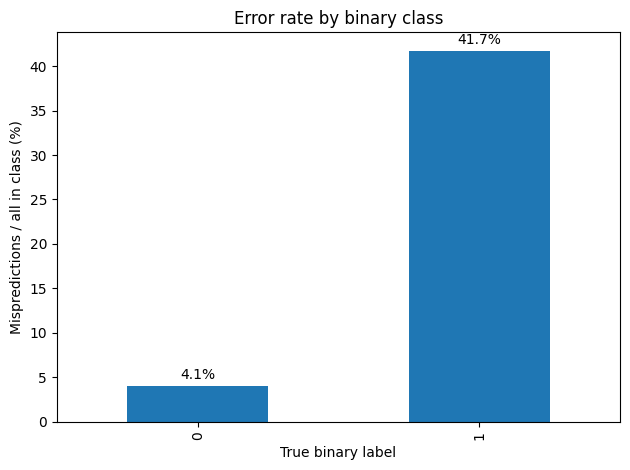

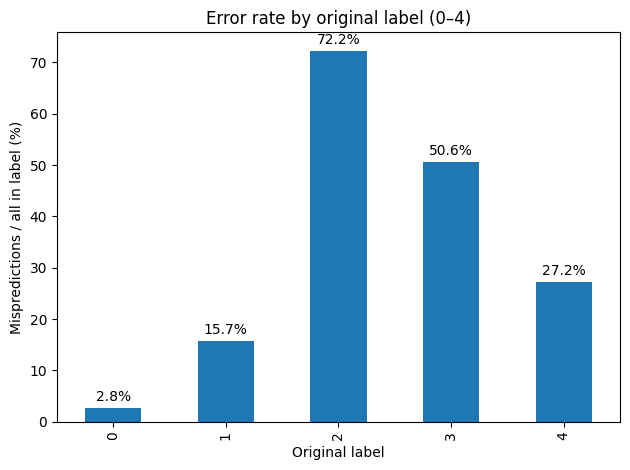

In [13]:
preds = np.asarray(preds, dtype=int)
err_df = dev_df.copy()
err_df["pred"] = preds
err_df["is_error"] = err_df["pred"] != err_df["binary_label"]

mispred = err_df[err_df["is_error"]].copy()

# Save examples
mispred_examples = mispred[["par_id", "label", "binary_label", "pred", "keyword", "text", "type_vector"]].copy()
mispred_examples.to_csv("dev_mispredictions.csv", index=False)

print("Dev size:", len(err_df))
print("Mispredictions:", len(mispred))
print("Saved: dev_mispredictions.csv")

# -----------------------------
# error rate per binary class:
# -----------------------------
bin_order = [0, 1]

total_per_bin = err_df["binary_label"].value_counts().reindex(bin_order).fillna(0).astype(int)
err_per_bin   = mispred["binary_label"].value_counts().reindex(bin_order).fillna(0).astype(int)

bin_err_rate = (err_per_bin / total_per_bin.replace(0, np.nan)) * 100.0
bin_err_rate = bin_err_rate.fillna(0.0)

plt.figure()
ax = bin_err_rate.plot(kind="bar")
plt.title("Error rate by binary class")
plt.xlabel("True binary label")
plt.ylabel("Mispredictions / all in class (%)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.show()

# -----------------------------
# error rate per original label (0–4): errors_in_label / total_in_label
# -----------------------------
orig_order = [0, 1, 2, 3, 4]   # ← added label 4

total_per_orig = err_df["label"].value_counts().reindex(orig_order).fillna(0).astype(int)
err_per_orig   = mispred["label"].value_counts().reindex(orig_order).fillna(0).astype(int)

# avoid division by zero
orig_err_rate = (err_per_orig / total_per_orig.replace(0, np.nan)) * 100.0
orig_err_rate = orig_err_rate.fillna(0.0)

plt.figure()
ax = orig_err_rate.plot(kind="bar")
plt.title("Error rate by original label (0–4)")  # updated title
plt.xlabel("Original label")
plt.ylabel("Mispredictions / all in label (%)")

# add numbers on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.show()


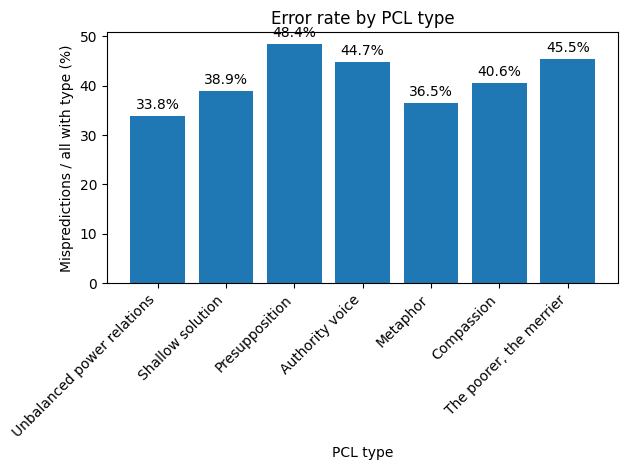

,par_id,label,binary_label,pred,keyword,text,type_vector
0,107,3.0,1,0,homeless,"""His present "" chambers "" may be quite humble,...","[0, 0, 0, 0, 0, 0, 1]"
1,149,2.0,1,0,disabled,Krueger recently harnessed that creativity to ...,"[1, 0, 0, 0, 0, 0, 1]"
2,151,3.0,1,0,poor-families,10:41am - Parents of children who died must ge...,"[1, 0, 0, 1, 0, 0, 0]"
4,157,4.0,1,0,poor-families,We are alarmed to learn of your recently circu...,"[1, 1, 0, 0, 1, 1, 0]"
9,432,2.0,1,0,refugee,He depicts demonstrations by refugees at the b...,"[0, 0, 0, 0, 0, 1, 0]"
12,582,3.0,1,0,homeless,"It 's calculated that over 204,000 days of pur...","[1, 0, 0, 0, 0, 0, 0]"
13,644,3.0,1,0,disabled,""" I and my daughter Monica are excited about p...","[1, 0, 0, 0, 0, 0, 0]"
16,773,3.0,1,0,immigrant,Sheepherding in America has always been an imm...,"[1, 0, 1, 0, 0, 1, 0]"
19,915,3.0,1,0,women,"""She continued, "" I stepped away from hiding b...","[0, 1, 0, 1, 1, 0, 0]"
20,952,4.0,1,0,homeless,"Bombarded by schizophrenia, addiction and home...","[0, 0, 0, 0, 1, 1, 0]"


In [14]:
# -----------------------------
# error rate per PCL type dimension
# -----------------------------
type_names = [
    "Unbalanced power relations",
    "Shallow solution",
    "Presupposition",
    "Authority voice",
    "Metaphor",
    "Compassion",
    "The poorer, the merrier",
]

# build a 2D matrix of type flags (N x K)
tv_all = err_df["type_vector"].dropna().tolist()
if len(tv_all) == 0:
    print("No type vectors available.")
else:
    K = len(tv_all[0])

    def stack_type_vectors(series, K):
        mat = np.zeros((len(series), K), dtype=int)
        for i, v in enumerate(series):
            vv = np.asarray(v, dtype=int)
            if len(vv) == K:
                mat[i, :] = vv
        return mat

    all_mat = stack_type_vectors(err_df["type_vector"].tolist(), K)
    err_mat = stack_type_vectors(mispred["type_vector"].tolist(), K)

    total_with_type = all_mat.sum(axis=0)   # denominator per type
    errs_with_type  = err_mat.sum(axis=0)   # numerator per type

    type_err_rate = (errs_with_type / np.where(total_with_type == 0, np.nan, total_with_type)) * 100.0
    type_err_rate = np.nan_to_num(type_err_rate, nan=0.0)

    plt.figure()
    bars = plt.bar(type_names[:K], type_err_rate)
    plt.title("Error rate by PCL type")
    plt.xlabel("PCL type")
    plt.ylabel("Mispredictions / all with type (%)")
    plt.xticks(rotation=45, ha="right")

    # add numbers on bars
    plt.bar_label(bars, fmt="%.1f%%", padding=3)

    plt.tight_layout()
    plt.show()

# show a few mispredictions
mispred_examples.head(15)

In [15]:
# -----------------------------
# mispredictions per PCL type
# -----------------------------
print("\n=== Example mispredictions per PCL type ===")

if len(tv_all) == 0:
    print("No type vectors available.")
else:
    for i, type_name in enumerate(type_names[:K]):
        # select mispredictions that have this type flag = 1
        subset = mispred[
            mispred["type_vector"].apply(
                lambda v: isinstance(v, (list, np.ndarray)) and len(v) > i and int(v[i]) == 1
            )
        ]

        print(f"\n--- {type_name} ---")
        print(f"Total mispredictions in this type: {len(subset)}")

        if len(subset) == 0:
            print("No mispredictions for this category.")
            continue

        # sample up to 3 examples
        examples = subset.head(5)

        for _, row in examples.iterrows():
            print("\npar_id:", row["par_id"])
            print("true label:", row["binary_label"], "| pred:", row["pred"])
            print("keyword:", row["keyword"])
            print("text:")
            print(row["text"])
            print("-" * 60)



=== Example mispredictions per PCL type ===

--- Unbalanced power relations ---
Total mispredictions in this type: 48

par_id: 149
true label: 1 | pred: 0
keyword: disabled
text:
Krueger recently harnessed that creativity to self-publish a book featuring the poems, artwork, photography and short stories of 16 ill or disabled artists from around the world. She hopes the book, which contains some of her own work as well, will show how talented disabled people can be.
------------------------------------------------------------

par_id: 151
true label: 1 | pred: 0
keyword: poor-families
text:
10:41am - Parents of children who died must get compensation, free medicine must be provided to poor families across UP: Ram Gopal Yadav
------------------------------------------------------------

par_id: 157
true label: 1 | pred: 0
keyword: poor-families
text:
We are alarmed to learn of your recently circulated proposals that would eviscerate the Lifeline program and leave many of the most vulner

In [16]:
# -----------------------------
# CORRECT predictions: 5 examples for "Unbalanced power relations"
# -----------------------------
print("\n=== Correctly predicted: Unbalanced power relations ===")

upr_index = type_names.index("Unbalanced power relations")

correct_upr = err_df[
    (err_df["is_error"] == False) &
    err_df["type_vector"].apply(
        lambda v: isinstance(v, (list, np.ndarray)) and len(v) > upr_index and int(v[upr_index]) == 1
    )
]

print("Total correct in this category:", len(correct_upr))

# take up to 5 examples
upr_examples = correct_upr.head(5)[
    ["par_id", "label", "binary_label", "pred", "keyword", "text"]
].copy()

# add a dedicated column just with the example text (as requested)
upr_examples["correct_unbalanced_power_example"] = upr_examples["text"]

upr_examples



=== Correctly predicted: Unbalanced power relations ===
Total correct in this category: 94


,par_id,label,binary_label,pred,keyword,text,correct_unbalanced_power_example
5,187,4.0,1,1,in-need,""" We share a global responsibility to respond ...",""" We share a global responsibility to respond ..."
6,232,3.0,1,1,in-need,The former Chelsea star through his foundation...,The former Chelsea star through his foundation...
7,350,4.0,1,1,homeless,It can not be right to allow homes to sit empt...,It can not be right to allow homes to sit empt...
8,369,4.0,1,1,women,""" People do n't understand the hurt, people do...",""" People do n't understand the hurt, people do..."
10,490,4.0,1,1,migrant,18 December should serve as a time when we loo...,18 December should serve as a time when we loo...



=== Misprediction rate by keyword ===


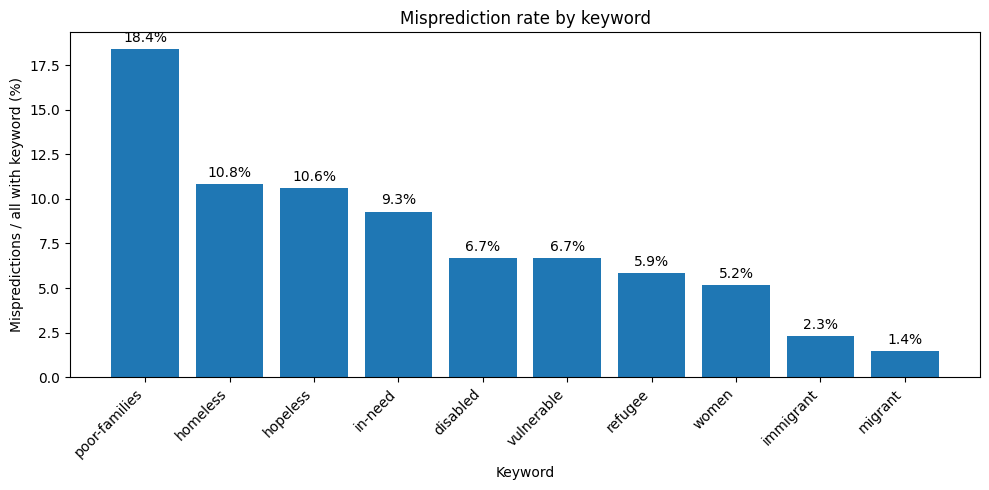

In [17]:
# -----------------------------
# GRAPH: misprediction rate by keyword
# -----------------------------
print("\n=== Misprediction rate by keyword ===")

# totals per keyword
total_per_kw = err_df["keyword"].value_counts()

# mispredictions per keyword
err_per_kw = mispred["keyword"].value_counts()

# align indexes
kw_stats = pd.DataFrame({
    "total": total_per_kw,
    "errors": err_per_kw
}).fillna(0)

# compute percentage
kw_stats["error_rate"] = (kw_stats["errors"] / kw_stats["total"]) * 100.0
kw_stats = kw_stats.sort_values("error_rate", ascending=False)

# optional: remove very rare keywords (unstable rates)
MIN_SAMPLES = 20
kw_stats_plot = kw_stats[kw_stats["total"] >= MIN_SAMPLES]

plt.figure(figsize=(10, 5))
bars = plt.bar(kw_stats_plot.index, kw_stats_plot["error_rate"])
plt.title("Misprediction rate by keyword")
plt.xlabel("Keyword")
plt.ylabel("Mispredictions / all with keyword (%)")
plt.xticks(rotation=45, ha="right")

# annotate bars
plt.bar_label(bars, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.show()



=== Percent of positive PCL by keyword ===


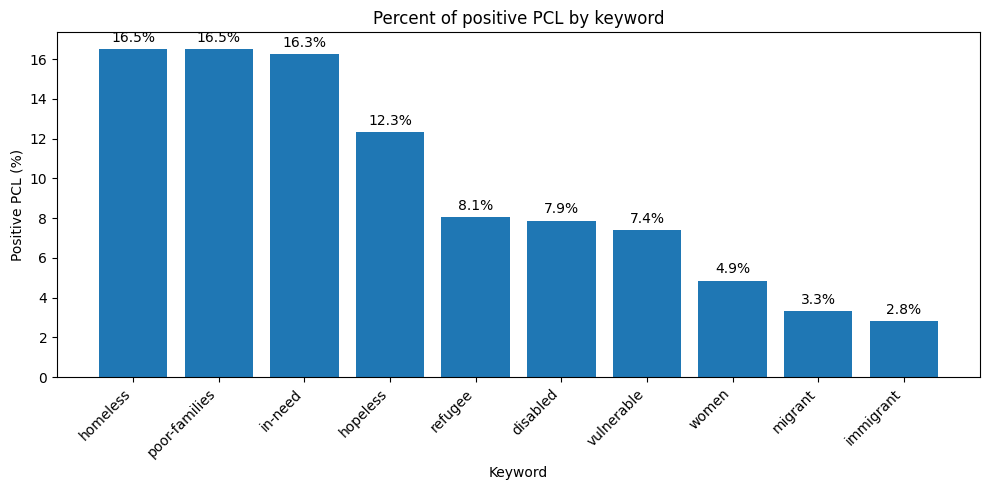

In [22]:
# -----------------------------
# GRAPH: percent of positive (PCL) by keyword
# -----------------------------
print("\n=== Percent of positive PCL by keyword ===")

# compute distribution
kw_stats = (
    df.groupby("keyword")["binary_label"]
      .value_counts()
      .unstack(fill_value=0)
      .rename(columns={0: "negative_nonPCL", 1: "positive_PCL"})
)

kw_stats["total"] = kw_stats["negative_nonPCL"] + kw_stats["positive_PCL"]
kw_stats["positive_rate_%"] = (
    kw_stats["positive_PCL"] / kw_stats["total"] * 100
)

# optional: filter rare keywords for stability
MIN_SAMPLES = 20
kw_stats_plot = kw_stats[kw_stats["total"] >= MIN_SAMPLES]

# sort for nicer visualization
kw_stats_plot = kw_stats_plot.sort_values("positive_rate_%", ascending=False)

# plot
plt.figure(figsize=(10, 5))
bars = plt.bar(kw_stats_plot.index, kw_stats_plot["positive_rate_%"])

plt.title("Percent of positive PCL by keyword")
plt.xlabel("Keyword")
plt.ylabel("Positive PCL (%)")
plt.xticks(rotation=45, ha="right")

# annotate bars
plt.bar_label(bars, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.show()


In [18]:
# -----------------------------
# 8) 3 mispredictions per keyword
# -----------------------------
print("\n=== Example mispredictions per keyword ===")

keywords = sorted(mispred["keyword"].dropna().unique())

for kw in keywords:
    subset = mispred[mispred["keyword"] == kw]

    print(f"\n--- Keyword: {kw} ---")
    print(f"Total mispredictions for this keyword: {len(subset)}")

    if len(subset) == 0:
        print("No mispredictions.")
        continue

    examples = subset.head(3)

    for _, row in examples.iterrows():
        print("\npar_id:", row["par_id"])
        print("true label:", row["binary_label"], "| pred:", row["pred"])
        print("original label:", row["label"])
        print("text:")
        print(row["text"])
        print("-" * 60)



=== Example mispredictions per keyword ===

--- Keyword: disabled ---
Total mispredictions for this keyword: 13

par_id: 149
true label: 1 | pred: 0
original label: 2.0
text:
Krueger recently harnessed that creativity to self-publish a book featuring the poems, artwork, photography and short stories of 16 ill or disabled artists from around the world. She hopes the book, which contains some of her own work as well, will show how talented disabled people can be.
------------------------------------------------------------

par_id: 644
true label: 1 | pred: 0
original label: 3.0
text:
" I and my daughter Monica are excited about providing a space for disabled people to be able to get together and earn fair prices for their work, " Mr. Rogers said."
------------------------------------------------------------

par_id: 1477
true label: 1 | pred: 0
original label: 3.0
text:
Haiti has legal protections for the disabled on paper, but the laws are poorly implemented. Disabled Haitians have fe

In [19]:
# -----------------------------
# Count frequency of labels 1–4
# -----------------------------
label_order = [0, 1, 2, 3, 4]

label_counts = (
    df["label"]
    .value_counts()
    .reindex(label_order)
    .fillna(0)
    .astype(int)
)

print("Counts for labels 1–4:")
print(label_counts)


Counts for labels 1–4:
label
0    8529
1     947
2     144
3     458
4     391
Name: count, dtype: int64


# Further Metrics

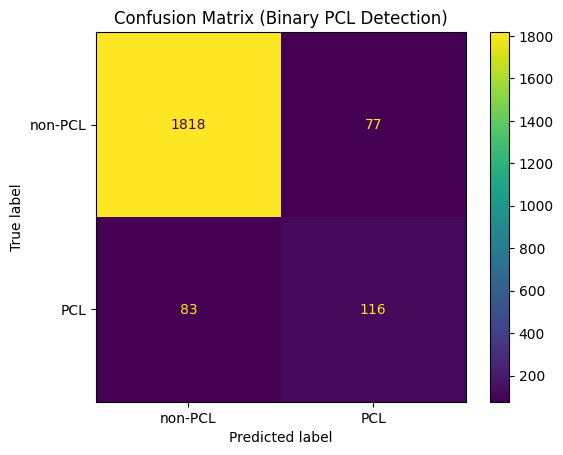

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = dev_df["binary_label"]
y_pred = preds

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-PCL", "PCL"])
disp.plot(values_format="d")

plt.title("Confusion Matrix (Binary PCL Detection)")
plt.show()
